### Computational simulation for Multi-Armed Bandit with Dynamic Programming

In [96]:
import numpy as np
import pandas as pd
import random
import time
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

#### set-up the environment: bandit

In [55]:
class Bandit:  # Environment
    def __init__(self, total_round, start_round):
        self.total_round = total_round
        self.current_round = start_round

    def set(self, rewards, actions):
        '''
        rewards --> dict: round: list of rewards (for each arm)
        actions --> dict: round: list of actions (select which arm) should be [0,1,2,3]
        '''
        self.rewards = rewards
        self.actions = actions

    def set_state(self, round):
        '''
        s --> tuple: (int,int)
        '''
        self.current_round = round

    def current_state(self):
        return self.current_round

    def is_terminal(self, round):
        return round != self.total_round

    def game_over(self):
        return self.current_round == self.total_round

    def move(self, action):
        # return reward if any
        self.current_round += 1
        return self.rewards[self.current_round][action]

    def all_states(self):
        '''
        gives us a set of all possible states in grid world
        '''
        return range(self.total_round)

#### set the parameters

In [69]:
thresh = 1e-4
GAMMA = 1
number_of_turns = 40
number_of_slot_machines = 4
conversion_rate = [0.9 for i in range(number_of_slot_machines)]
ACTIONS = list(range(number_of_slot_machines))
sim_total = 50

#### play the game via DP (value iteration)

In [82]:
rewards_df = []
raw_policies_df = []
sum_policies_df = []

sim_total = sim_total
for sim in range(sim_total):
    
    '''
    create new dataset each time
    '''
    def bandit(number_of_turns, conversion_rate, number_of_slot_machines):
        bandit = Bandit(total_round=number_of_turns, start_round=0)

        np.random.seed(int(time.time()))
        rewards_np = np.zeros((number_of_turns, number_of_slot_machines))
        for slot_machine_index in range(number_of_slot_machines):
            rewards_np[
                np.random.choice(np.arange(number_of_turns), int(conversion_rate[slot_machine_index] * number_of_turns),
                                 replace=False), slot_machine_index] = 1
        rewards_df.append(rewards_np)

        rewards = {i: rewards_np[i].tolist() for i in range(number_of_turns)}
        actions = {i: list(range(number_of_slot_machines)) for i in range(number_of_turns - 1)}
    
        bandit.set(rewards, actions)
        return bandit

    # instantiate the bandit
    B = bandit(number_of_turns, conversion_rate, number_of_slot_machines)
    
    
    '''
    value iteration
    '''

    # randomly instantiate
    policy = {}
    for s in B.actions.keys():
        policy[s] = np.random.choice(ACTIONS)

    # initialize V(s) randomly between 0 and 1
    V = {}
    states = B.all_states()
    for s in states:
        if s in B.actions:
            V[s] = np.random.random()
        else:
            # terminal state so we set Value to 0
            V[s] = 0

    # repeat until convergence
    # V[s] = max[a]{sum[s',r] {p(s',r|s,a)[r + GAMMA * V[s']]}}
    while True:
        max_change = 0
        for s in states:
            old_vs = V[s]

            # V[s] only has policy if not a terminal state
            if s in policy:
                new_v = float('-inf')

                # find max[a]
                # random.shuffle(ACTIONS)
                for a in ACTIONS:
                    B.set_state(s)
                    r = B.move(a)
                    v = r + GAMMA * V[B.current_state()]
                    if v > new_v:
                        new_v = v
                V[s] = new_v
                max_change = max(max_change, np.abs(old_vs - V[s]))

        # when the value function converges break out of the loop
        if max_change < thresh:
            break

    '''
    find the optimal policy
    '''        
    # find a policy that leads to optimal value function
    for s in policy.keys():
        best_act = None
        best_value = float('-inf')
        # random.shuffle(ACTIONS)
        for a in ACTIONS:
            B.set_state(s)
            r = B.move(a)
            v = r + GAMMA * V[B.current_state()]
            if v > best_value:
                best_value = v
                best_act = a
        policy[s] = best_act

    # see results
    raw_policies_df.append(list(policy.values()))
    sum_policies_df.append(Counter(list(policy.values())))
    
    sim += 1
    time.sleep(1)

#### visualize results

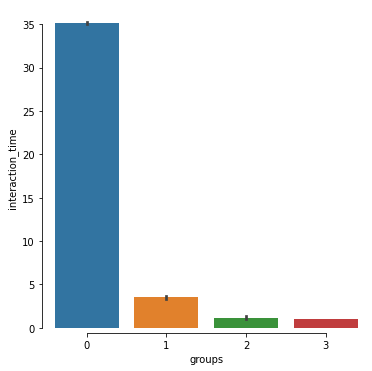

In [120]:
# visualize interaction time.
widedf = pd.DataFrame(sum_policies_df)
widedf['turn'] = list(range(sim_total))
longdf = pd.melt(widedf, id_vars=['turn'], value_vars=[0, 1, 2, 3],
                var_name='groups', value_name='interaction_time')

ax = sns.catplot(x='groups', y='interaction_time', kind="bar", data=longdf)
sns.despine(offset=5, trim=True)
plt.show()

In [166]:
longdf.groupby(['groups']).mean()

,turn,interaction_time
groups,,
0,24.5,35.180000
1,24.5,3.500000
2,24.5,1.153846
3,24.5,1.000000


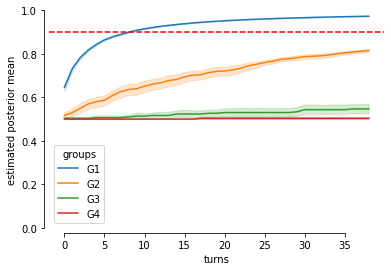

In [167]:
# calculate posterior mean.
posterior_mean = []

for sim in range(sim_total):
    
    reward_each_round = rewards_df[sim][1:]
    machine_played_each_round = raw_policies_df[sim]

    d={i:[] for i in range(number_of_slot_machines)}
    number_of_positive_rewards={i:1 for i in range(number_of_slot_machines)}
    number_of_negative_rewards={i:1 for i in range(number_of_slot_machines)}
    for turn_index in range(len(machine_played_each_round)):
        for slot_machine_index in range(number_of_slot_machines):
            if slot_machine_index == machine_played_each_round[turn_index]:
                if reward_each_round[turn_index][slot_machine_index]==1:
                    number_of_positive_rewards[slot_machine_index]+=1
                else:
                    number_of_negative_rewards[slot_machine_index]+=1

            a = number_of_positive_rewards[slot_machine_index]
            b = number_of_negative_rewards[slot_machine_index]
            d[slot_machine_index].append(a/(a+b))

    dd = np.array([d[0],d[1],d[2],d[3]])
    flatten_dd = dd.flatten('F')
    
    posterior_mean.extend(flatten_dd)
    
    sim += 1
    
    
# visualize posterior mean.
turn = []
for i in range(number_of_turns-1):
    turn += [i] * number_of_slot_machines
turns = turn * sim_total
arms = ['G1', 'G2', 'G3', 'G4'] * (number_of_turns-1) * sim_total
df = pd.DataFrame(list(zip(turns, arms, posterior_mean)), columns=['turns','groups','posterior_mean'])
ax = sns.lineplot(x="turns", y="posterior_mean", hue="groups", data=df)
ax.set(xlabel='turns', ylabel='estimated posterior mean')
ax.set(ylim=(0, 1))
ax.axhline(.90, ls='--',color='r')
sns.despine(offset=5, trim=True)
plt.show()    

In [165]:
df.groupby(['groups']).mean()

,turns,posterior_mean
groups,,
G1,19,0.921648
G2,19,0.703915
G3,19,0.525043
G4,19,0.501880
